In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.fftpack import fft, irfft
from scipy.signal import detrend

In [4]:
# Conducting exploratory analysis on engine data
df = pd.read_csv("./CMaps/train_FD001.txt", delimiter=' ')

In [75]:
# Opening of data reveals that there is no data labels so I am naming them here
column_names = ["unit_number","cycle_number","operational_setting_1","operational_setting_2","operational_setting_3"]

print("Number of columns in data:", len(df.columns))

# The rest of the columns are sensor measurements, let's label the remaining by an index 
for k in range(1,len(df.columns)-len(column_names)+1):
    column_names.append("sensor_measurement_{}".format(k))

df.columns = column_names

Number of columns in data: 28


In [77]:
# Exploring the renamed data
df.head()

unit_number  cycle_number  operational_setting_1  operational_setting_2  \
0            1             2                 0.0019                -0.0003   
1            1             3                -0.0043                 0.0003   
2            1             4                 0.0007                 0.0000   
3            1             5                -0.0019                -0.0002   
4            1             6                -0.0043                -0.0001   

   operational_setting_3  sensor_measurement_1  sensor_measurement_2  \
0                  100.0                518.67                642.15   
1                  100.0                518.67                642.35   
2                  100.0                518.67                642.35   
3                  100.0                518.67                642.37   
4                  100.0                518.67                642.10   

   sensor_measurement_3  sensor_measurement_4  sensor_measurement_5  ...  \
0               1591.82               1403.14                 14.62  ...   
1               1587.99               1404.20                 14.62  ...   
2               1582.79               1401.87                 14.62  ...   
3               1582.85               1406.22                 14.62  ...   
4               1584.47               1398.37                 14.62  ...   

   sensor_measurement_14  sensor_measurement_15  sensor_measurement_16  \
0                8131.49                 8.4318                   0.03   
1                8133.23                 8.4178                   0.03   
2                8133.83                 8.3682                   0.03   
3                8133.80                 8.4294                   0.03   
4                8132.85                 8.4108                   0.03   

   sensor_measurement_17  sensor_measurement_18  sensor_measurement_19  \
0                    392                   2388                  100.0   
1                    390                   2388                  100.0   
2                    392                   2388                  100.0   
3                    393                   2388                  100.0   
4                    391                   2388                  100.0   

   sensor_measurement_20  sensor_measurement_21  sensor_measurement_22  \
0                  39.00                23.4236                    NaN   
1                  38.95                23.3442                    NaN   
2                  38.88                23.3739                    NaN   
3                  38.90                23.4044                    NaN   
4                  38.98                23.3669                    NaN   

   sensor_measurement_23  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  

[5 rows x 28 columns]

In [78]:
# Let's make sure that I am selecting the correct data, I want the longest/shorted lived units
# Determined by exploratory_analysis_engine_data.ipynb
long_short_living_units = df[(df["unit_number"]==69) | (df["unit_number"]==39) ]

print("Units in this dataset: {}".format( long_short_living_units["unit_number"].unique()))
long_short_living_units.head()

Units in this dataset: [39 69]


unit_number  cycle_number  operational_setting_1  operational_setting_2  \
7509           39             1                -0.0004                -0.0002   
7510           39             2                -0.0062                 0.0002   
7511           39             3                 0.0007                -0.0000   
7512           39             4                -0.0039                 0.0005   
7513           39             5                 0.0039                 0.0002   

      operational_setting_3  sensor_measurement_1  sensor_measurement_2  \
7509                  100.0                518.67                642.72   
7510                  100.0                518.67                642.61   
7511                  100.0                518.67                642.26   
7512                  100.0                518.67                642.46   
7513                  100.0                518.67                642.31   

      sensor_measurement_3  sensor_measurement_4  sensor_measurement_5  ...  \
7509               1592.37               1410.00                 14.62  ...   
7510               1586.25               1407.99                 14.62  ...   
7511               1586.25               1407.48                 14.62  ...   
7512               1587.90               1405.23                 14.62  ...   
7513               1587.08               1408.78                 14.62  ...   

      sensor_measurement_14  sensor_measurement_15  sensor_measurement_16  \
7509                8133.27                 8.4451                   0.03   
7510                8126.00                 8.4279                   0.03   
7511                8123.32                 8.4143                   0.03   
7512                8123.19                 8.4599                   0.03   
7513                8125.88                 8.4607                   0.03   

      sensor_measurement_17  sensor_measurement_18  sensor_measurement_19  \
7509                    392                   2388                  100.0   
7510                    395                   2388                  100.0   
7511                    394                   2388                  100.0   
7512                    394                   2388                  100.0   
7513                    394                   2388                  100.0   

      sensor_measurement_20  sensor_measurement_21  sensor_measurement_22  \
7509                  38.90                23.2947                    NaN   
7510                  38.82                23.4604                    NaN   
7511                  38.73                23.2669                    NaN   
7512                  38.82                23.3789                    NaN   
7513                  38.73                23.3338                    NaN   

      sensor_measurement_23  
7509                    NaN  
7510                    NaN  
7511                    NaN  
7512                    NaN  
7513                    NaN  

[5 rows x 28 columns]

In [81]:
# What are the number of cycles that these units survived?
longest_cycles = long_short_living_units[long_short_living_units["unit_number"]==69]["cycle_number"].max()
shortest_cycles = long_short_living_units[long_short_living_units["unit_number"]==39]["cycle_number"].max()
print("Max cycles: {} unit 39 ".format(shortest_cycles))
print("Max cycles: {} unit 69".format(longest_cycles))

Max cycles: 128 unit 39 
Max cycles: 362 unit 69


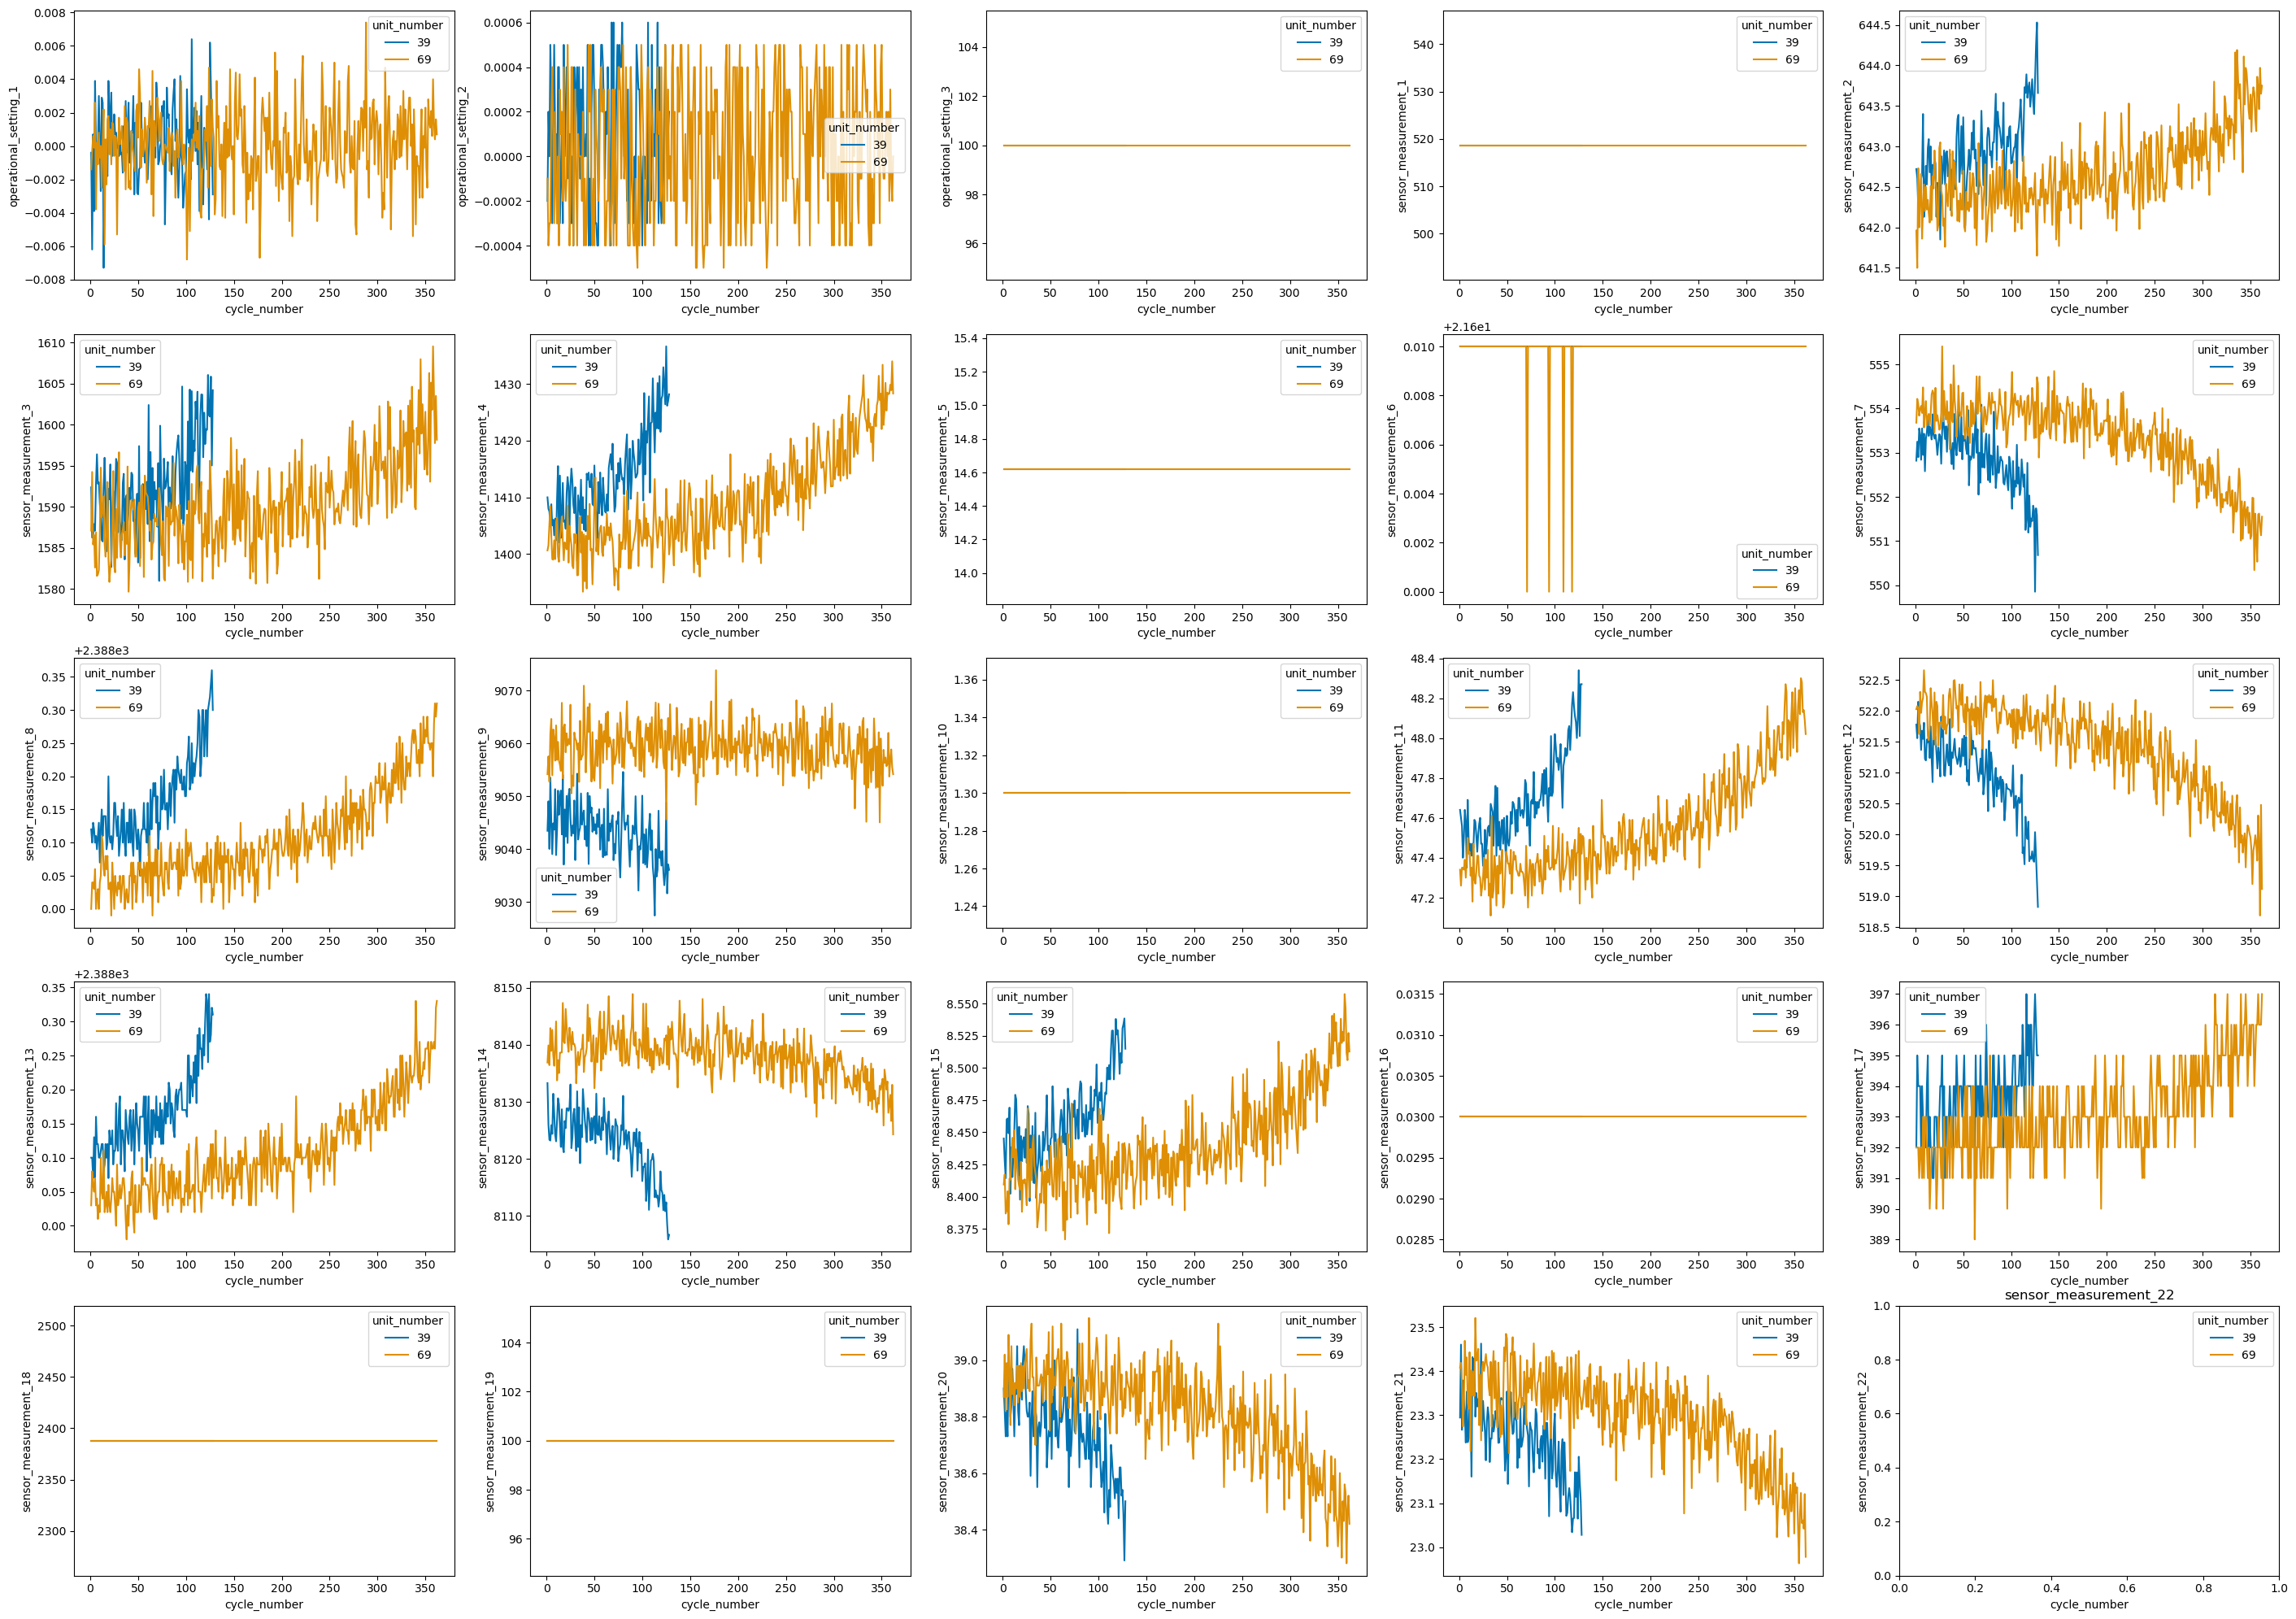

In [86]:
# Let's take a look at the sensor data for units 69 and 39 which are the longest and shortest living units

# There are 26 sensors, 24 with meaningful data so let's make a 5 by 5 grid, the last 2 are NAN plots anyway
fig, axes = plt.subplots(5, 5, figsize=(35, 25))
# fig.suptitle("Longest vs Shortest living engine")
for var, ax in zip(list(df.columns)[2:], axes.flat):
    # print(var)
    sns.lineplot(data = long_short_living_units , x = "cycle_number", y = var, hue=long_short_living_units["unit_number"], 
                 palette="colorblind",
                 ax=ax
                )
    plt.title(var)

# Ok so, I guess it makes sense that the sensor data is VERY different between the two

In [136]:
# Taken from TagUp Data science page
# Let's try to use the frequency filter approach on the TagUp data science page
from scipy.signal import butter, lfilter
def lowpass_filter(signal, cutoff, fs, order=2):
    """
    Remove harmonic components above the cutoff frequency.

    Arguments:
        signal: the input signal as a 1-D array.
        cutoff: the filter cutoff frequency.
        fs: the sampling frequency of the input signal.
        order: order of the filter.
    """
    nyquist = fs / 2
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, signal)

def highpass_filter(signal, cutoff, fs, order=2):
    """
    Remove harmonic components above the cutoff frequency.

    Arguments:
        signal: the input signal as a 1-D array.
        cutoff: the filter cutoff frequency.
        fs: the sampling frequency of the input signal.
        order: order of the filter.
    """
    nyquist = fs / 2
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return lfilter(b, a, signal)


In [88]:
def magnitude_filter(unfiltered_signal, percent_threshold=0.1):
    '''
    Description:
    --------------
    A function that applies a selection to the signal based on a magnitude threshold
    Only the largest contributing frequency is kept, as well as frequencies that are  percent_threshold*max(unfiltered_signal)

    Arguments:
    ------------
    unfiltered_signal: 
    percent_threshold: The threshold for the magnitude
    '''
    # Extracting the frequency magnitudes from the signal array
    magnitude = np.abs(unfiltered_signal)

    # Remove frequencies with magnitudes lower percent_threshold of max magnitude, only keep the highest contributing to signal
    threshold = percent_threshold * np.max(magnitude)

    # Clone the signal to not adjust the array in place, unfiltered_signal is needed for plotting later
    signal_clone = unfiltered_signal.copy()

    # Set any frequencies lower than the threshold to zero, removing them from the reconstructed 
    signal_clone[magnitude < threshold] = 0
    
    # Reconstruct signal using inverse Fourier transform and keep real part
    filtered_signal = irfft(signal_clone) 
    
    return filtered_signal


In [151]:
# Create a signal plot book for the engine
def denoise_engine_signal_one_var(engine_nums, dataframe, variable, start_stop_index=[0,0]):
    '''
    Description:
    ---------------
    A function that takes in a series of engines, and makes plots of
    1. The original signal measurement as seen in the data,
    2. A plot of the signal distribution that has the data shift/trend removed (necessary for denoising)
    3. A spectral decomposition of the signal after it is stabilized to reveal the largest contributing frequencies
    4. A plot of the signal distribution once it has been denoised, and only contains the largest contributing frequencies

    Inputs:
    -------
    engine_nums: The set of engine signal plots you want to denoise and overlay, should be passed as a string "39,69"
    dataframe: The pandas data frame that contains the engine sensor data
    variable: The sensor signal distributions you wish to plot, "signal_measurement_1", etc.
    start_stop_index: An array that specifies the start and stop index of the slice that you wish to denoise and plot
    
    '''

    # There are 26 sensors, 24 with meaningful data so let's make a 1 by 4 grid to show all of the planned plots
    fig, axes = plt.subplots(1, 4, figsize=(10, 5))
    fig.suptitle("Engine No. {}".format(engine_nums))

    # Will attempt to denoise the signal plots using a Fourier decomposition (Inspired by the TagUp submission)
    fs = 200 # 100 Hertz, taken as a trial frequency decomp
    nyq_f = fs / 2  # Nyquist frequency [Hz]

    # Processing the input string specifying the engines , whose characteristics we will plot.
    engine_nums = [int(a) for a in engine_nums.split(",")]
    
    # Loop over the engines 
    for engine_num in engine_nums:

        # Gather the signal distribution of the ending and variable of interest
        signal = dataframe[dataframe["unit_number"]==engine_num][variable].values

        
        if start_stop_index != [0,0]:
            signal = signal[start_stop_index[0]:start_stop_index[1]]

        
        # Removing the signal shift by subtracting a linear fit of the trend
        detrended_signal = detrend(signal,type="linear")
    
        
        # Taking the magnitude of the components and scaling by frequency
        fft_signal = np.abs(fft(detrended_signal, fs)) / fs
    
            
        
        # Extracting positive and negative components
        dc_component = fft_signal[0]
        positive_spectrum = fft_signal[1:int(nyq_f)]
        negative_spectrum = fft_signal[int(nyq_f) + 1:]
        
        # Summing the amplitudes of the frequencies, creating a frequency decomp. plot
        spectrum = np.hstack((negative_spectrum, dc_component, positive_spectrum))
    
        
        # Creeating the frequency axis
        frequencies = np.arange(0, len(spectrum)) - len(spectrum) // 2 + 1
    
        
        
        # Apply selection to frequency, and reconstruct
        cutoff = 2
        # denoised_signal = irfft(lowpass_filter(detrended_signal, cutoff, fs, order=4))
        # denoised_signal = irfft(highpass_filter(detrended_signal, cutoff, fs, order=4))
        

        # Applying a filter based on magnitude, not signal spectrum
        denoised_signal = magnitude_filter(detrended_signal, percent_threshold=.99)
    
        # Setting plot labels and plotting
        axes[0].set_title("Original \n" + variable[variable.find("_")+1:])
        axes[0].set_xlabel("Cycle Number")
        axes[0].set_ylabel("Measurement")
        axes[0].plot(signal)
    
        axes[1].set_title("Detrended \n" + variable[variable.find("_")+1:])
        axes[1].set_xlabel("Cycle Number")
        axes[1].set_ylabel("Shifted Measurement")
        axes[1].plot(detrended_signal)
    
        axes[2].set_title("Frequency spectrum of \n" + variable[variable.find("_")+1:])
        axes[2].set_xlabel("Frequency [Hz]")
        axes[2].set_ylabel("Amplitude")
        axes[2].plot(frequencies,spectrum)
    
        axes[3].set_title("Denoised \n" + variable[variable.find("_")+1:])
        axes[3].set_xlabel("Cycle Number")
        axes[3].set_ylabel("Amplitude")
        axes[3].plot(denoised_signal)
    
            
    plt.tight_layout()

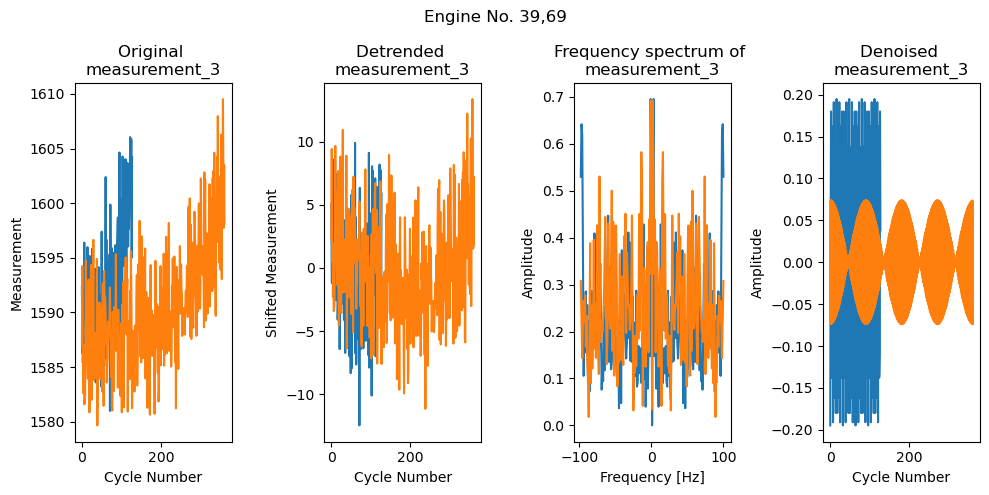

In [152]:
# Making de-noised signal plots for the shortest (39) and longest (69) lived engines 
denoise_engine_signal_one_var("39,69", df, "sensor_measurement_3", start_stop_index=[0,2000])

/var/folders/qj/3zmdfhnn4bxgc68lbfycnlt40000gn/T/ipykernel_97771/181113807.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 4, figsize=(10, 5))


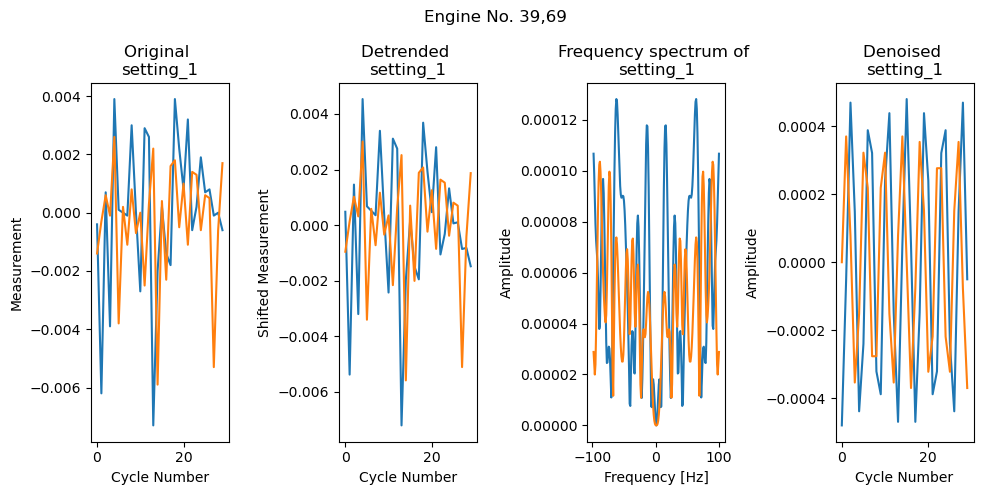

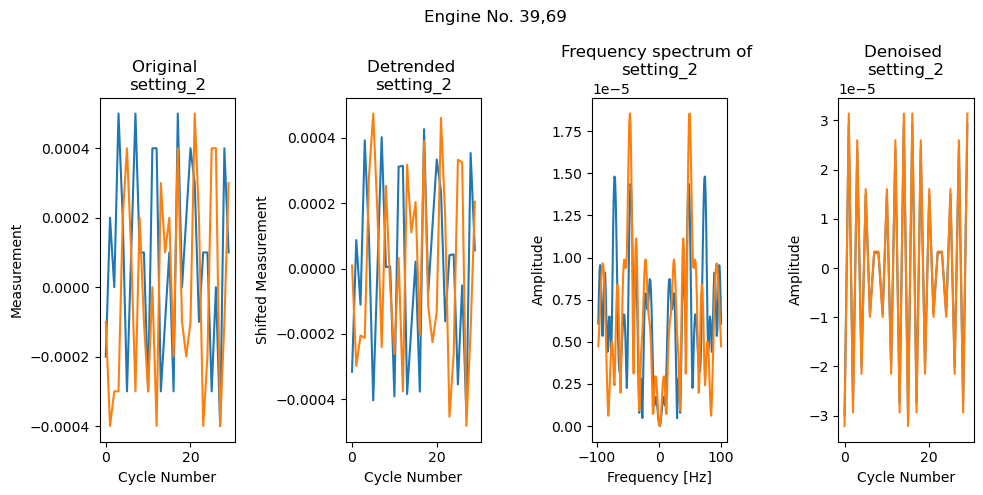

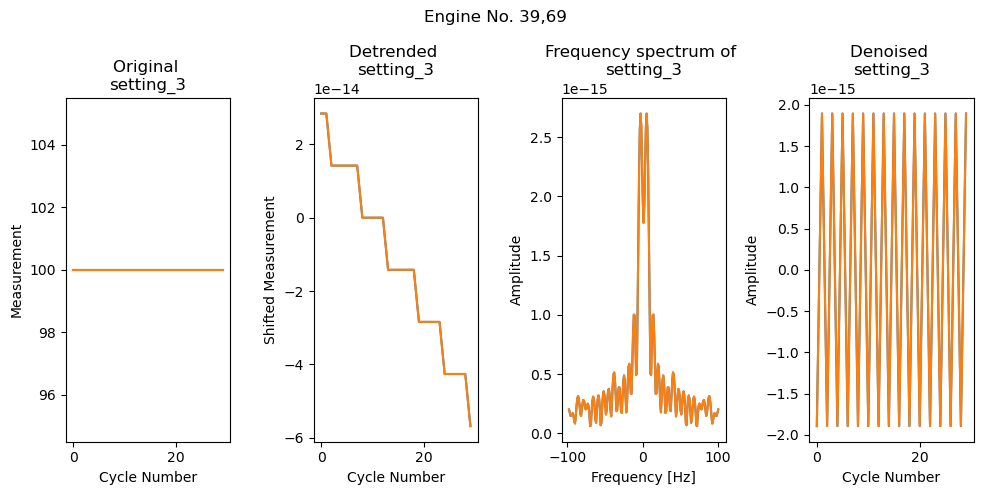

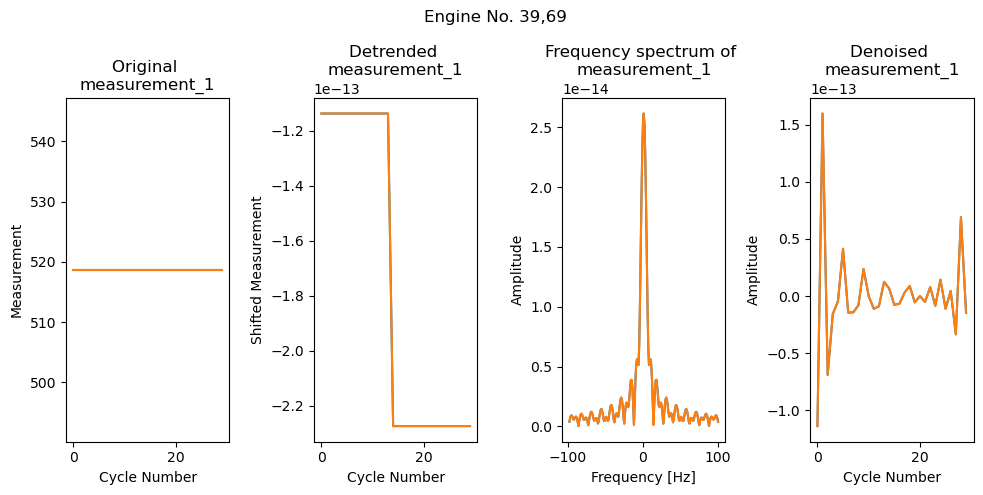

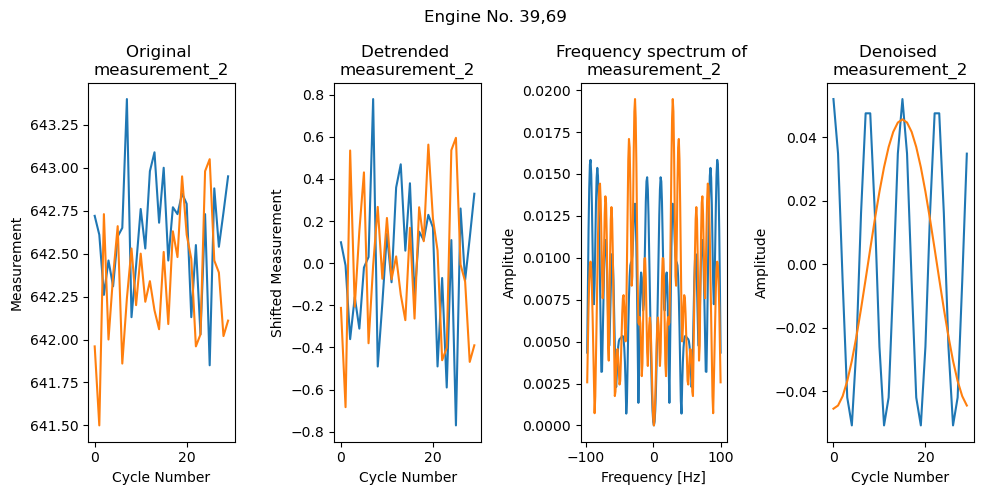

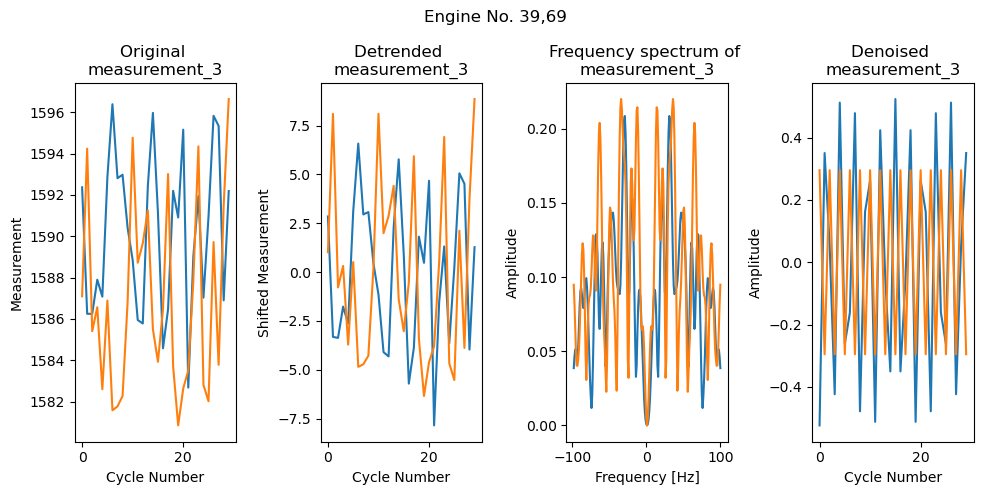

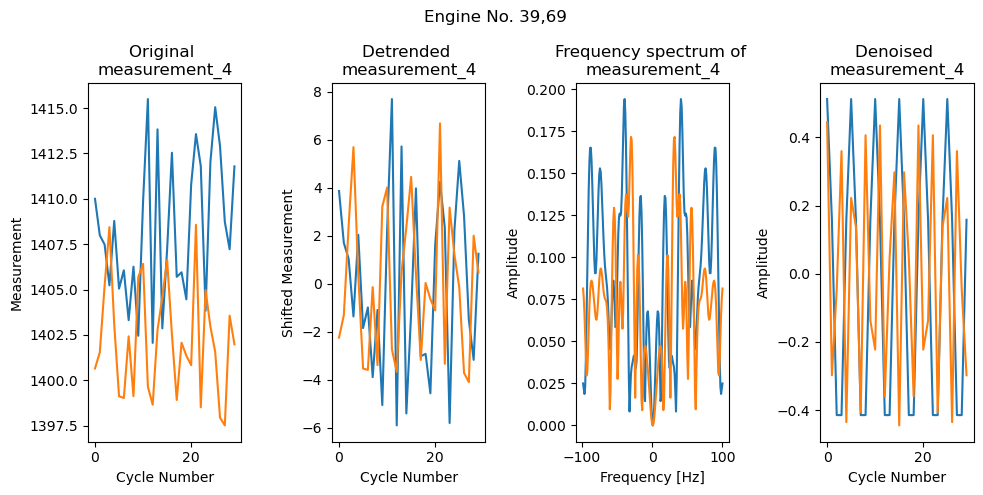

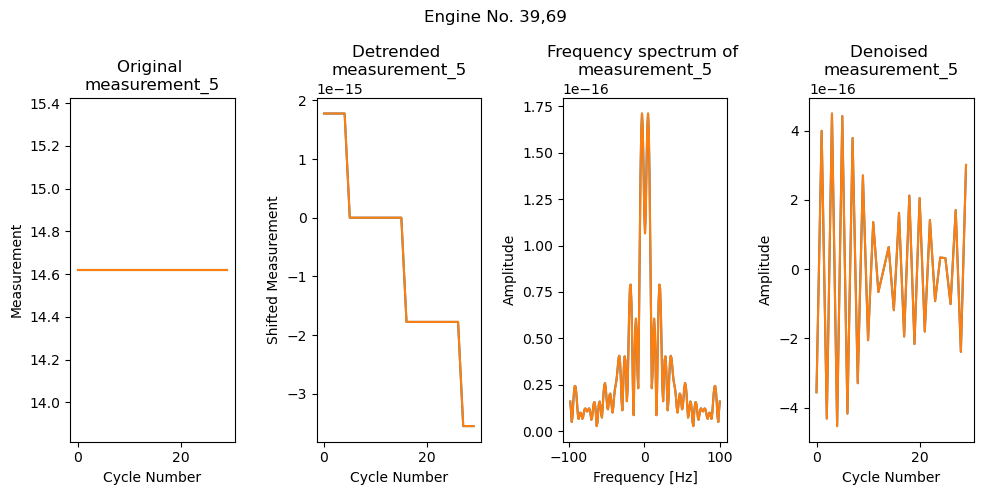

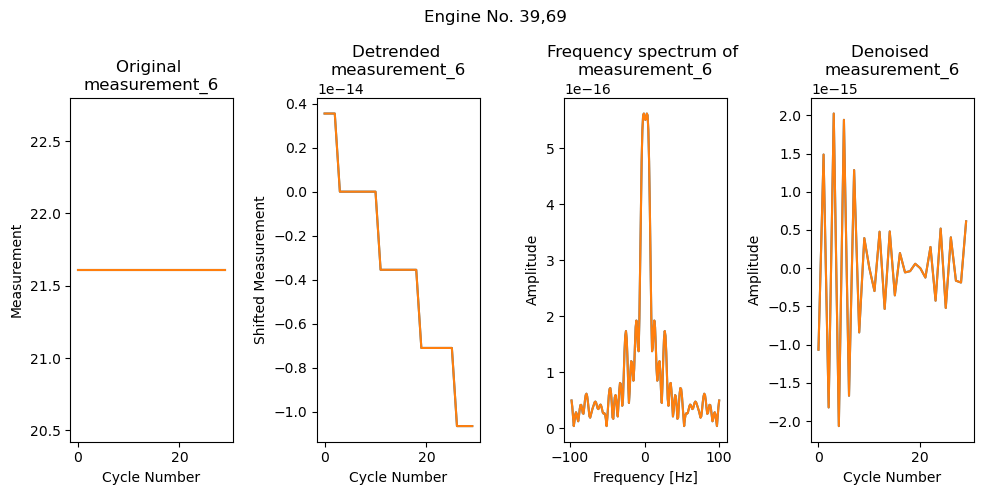

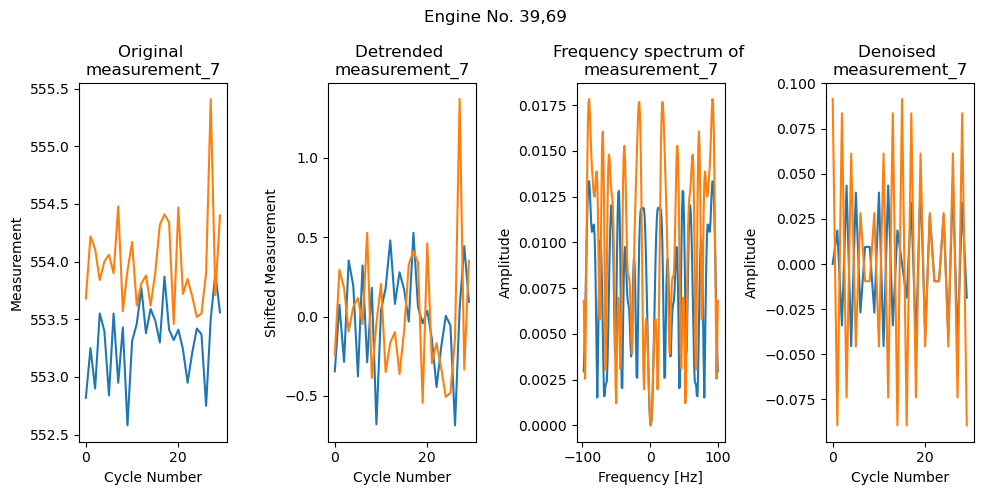

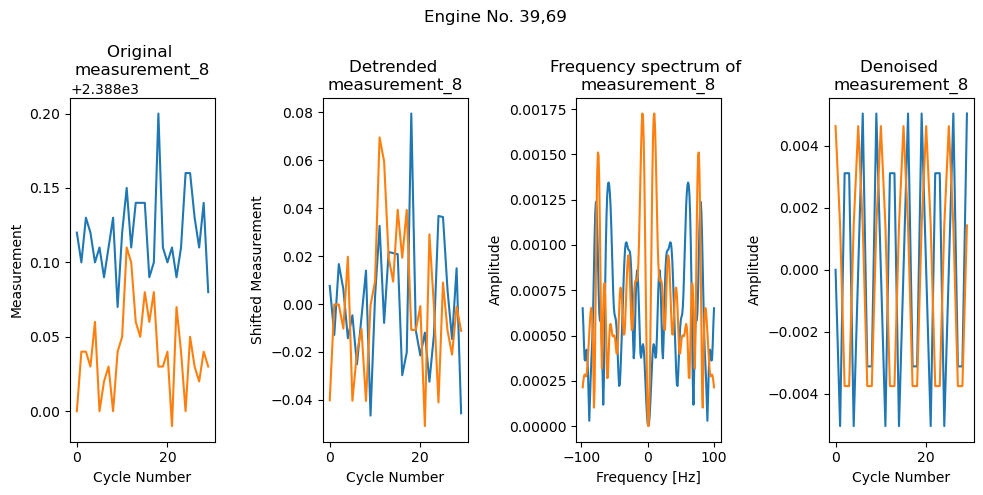

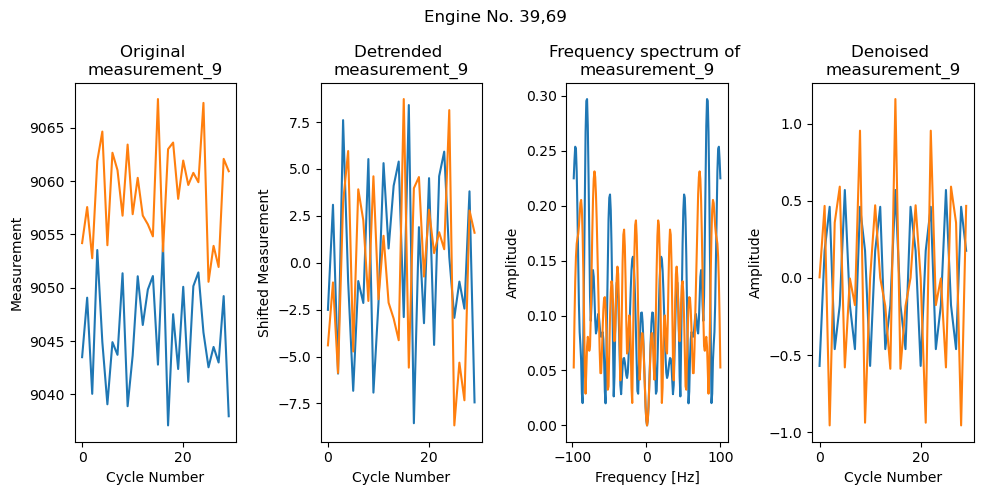

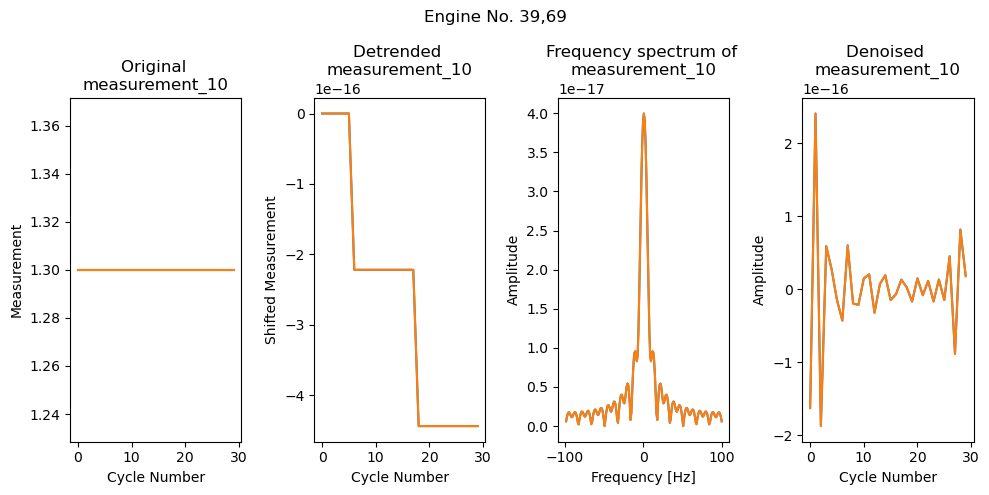

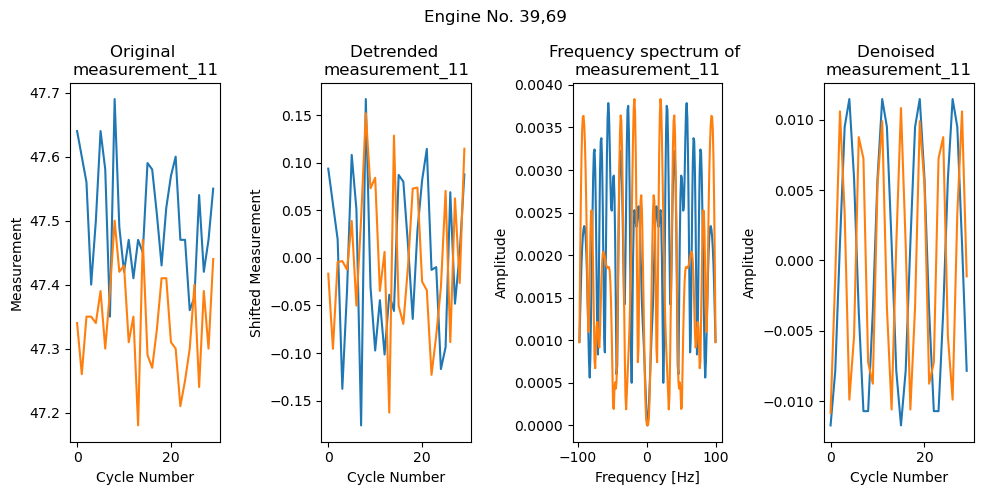

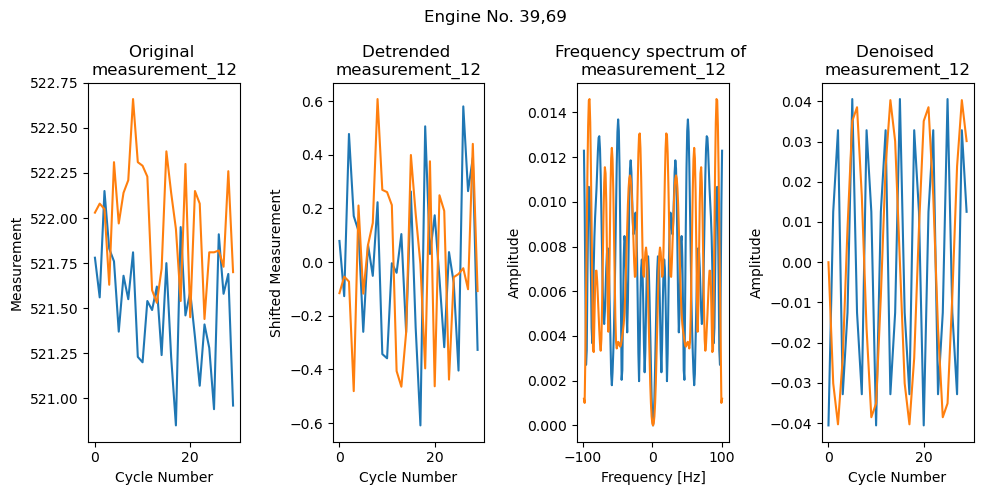

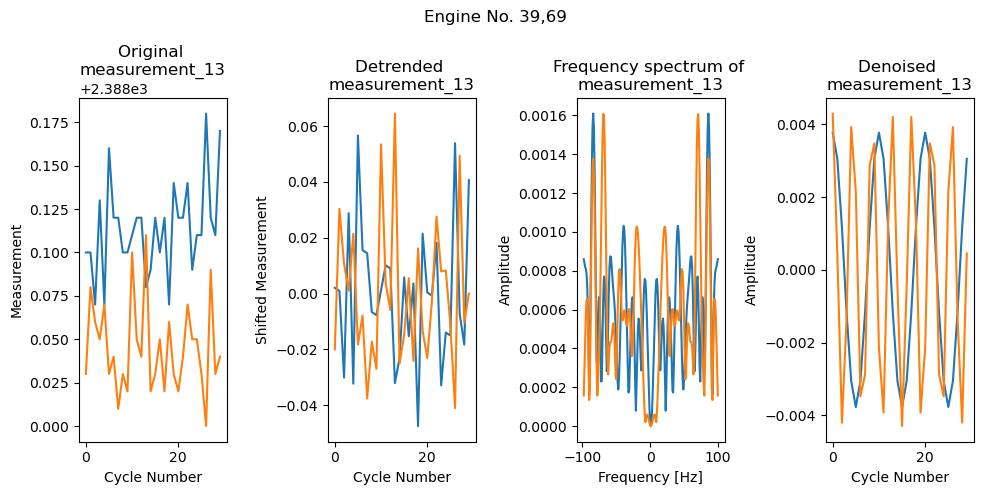

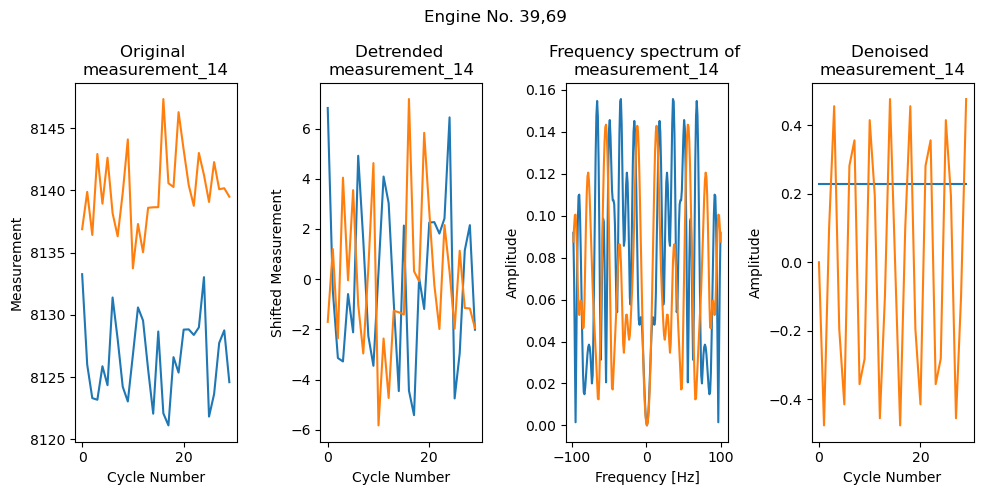

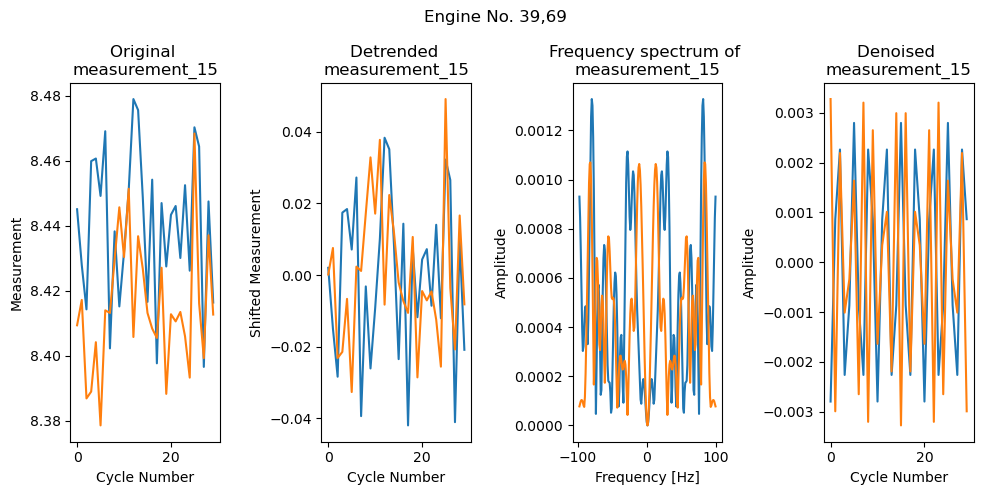

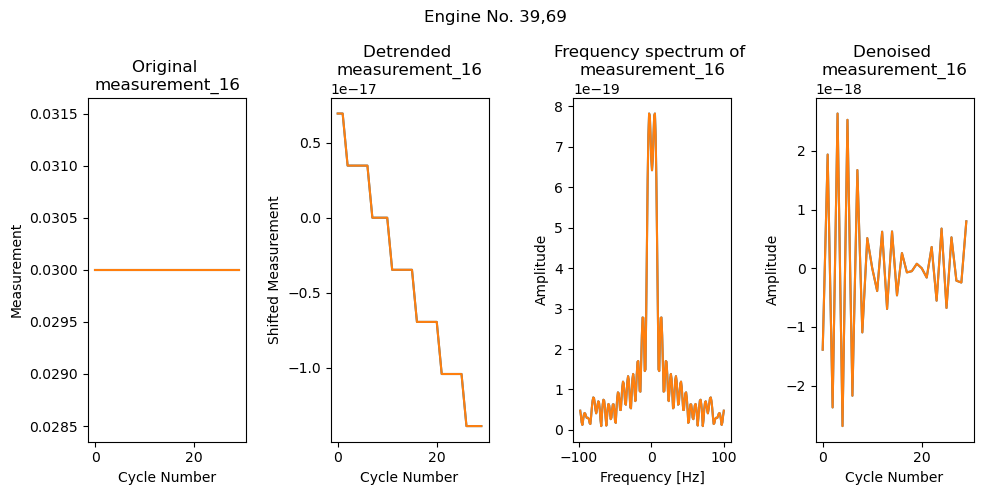

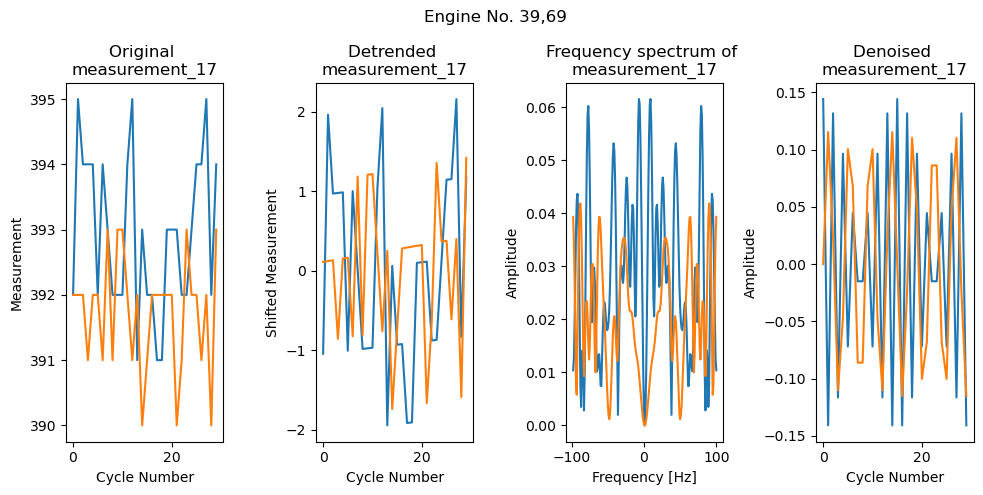

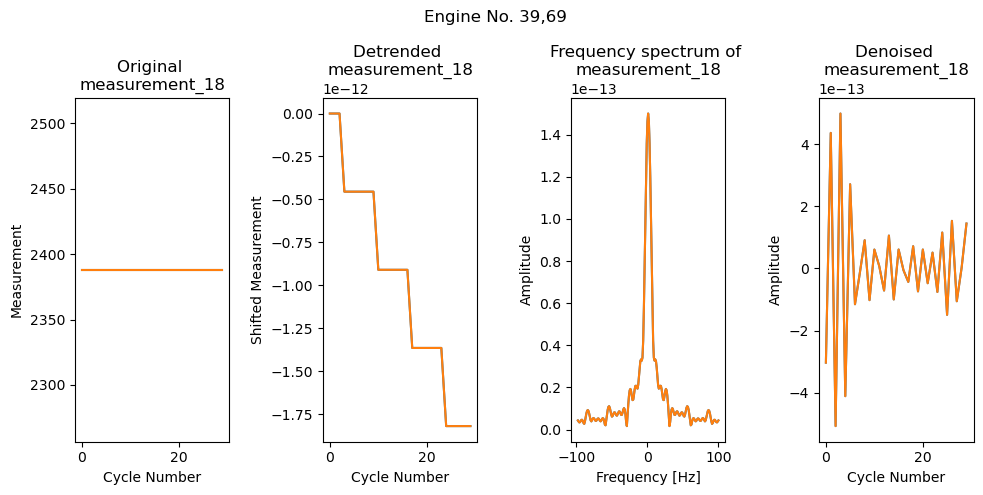

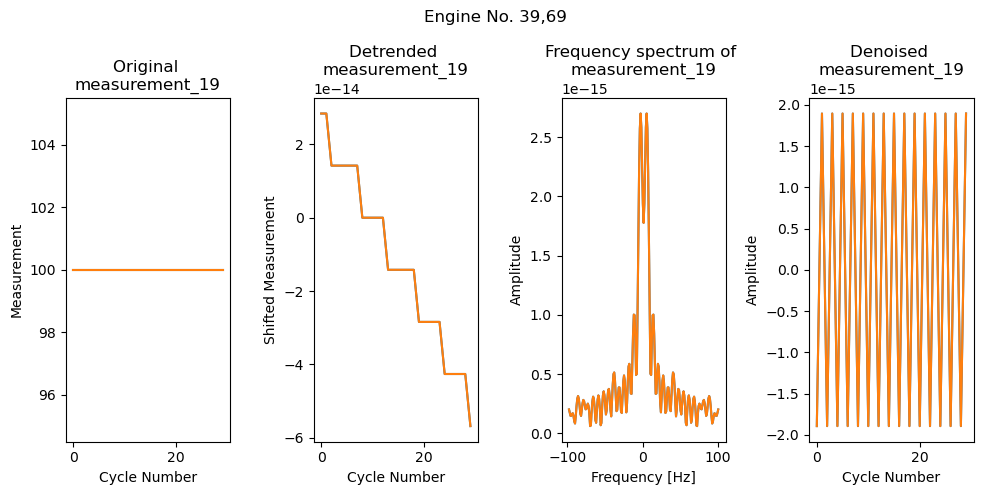

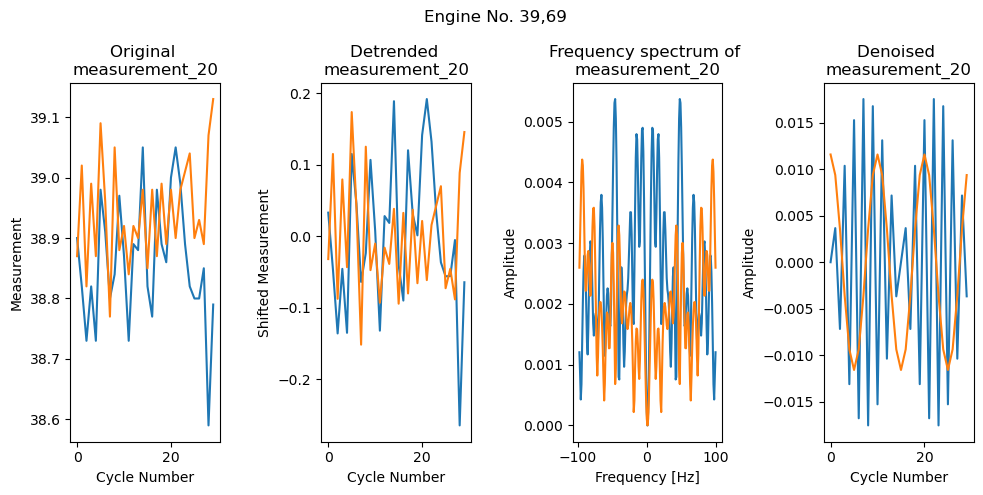

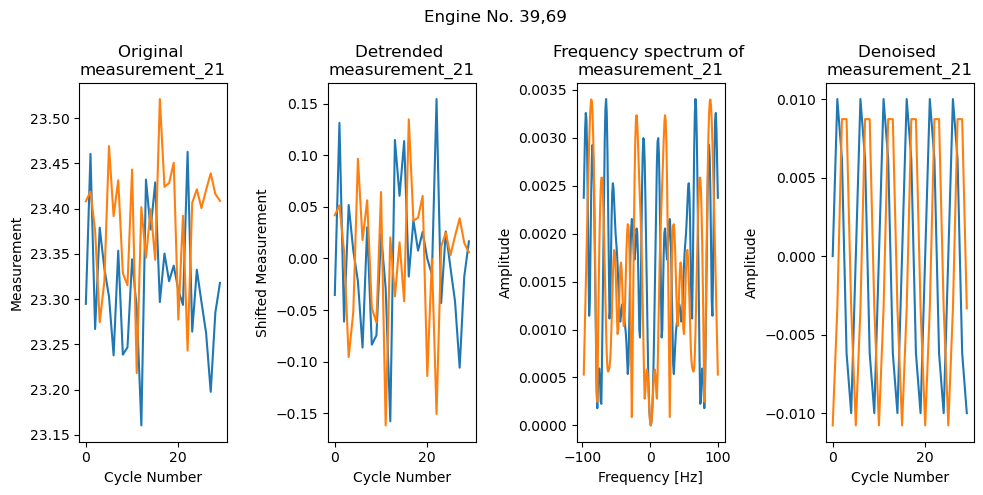

In [162]:
# Let's compare the denoised plots of the longest and shorted lived engines
for var in list(df.columns)[2:-2]:
    # print(var)
    denoise_engine_signal_one_var("39,69", df, var, start_stop_index=[0,30])

/var/folders/qj/3zmdfhnn4bxgc68lbfycnlt40000gn/T/ipykernel_97771/181113807.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 4, figsize=(10, 5))


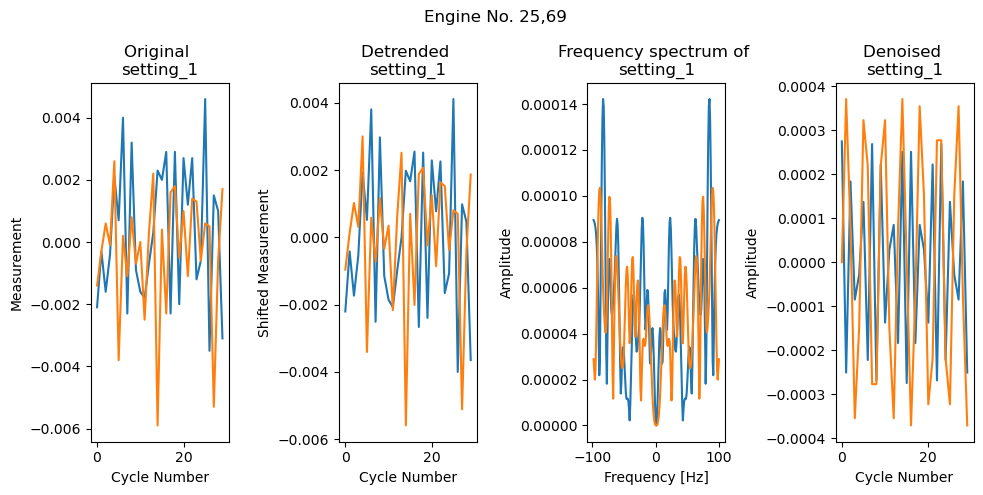

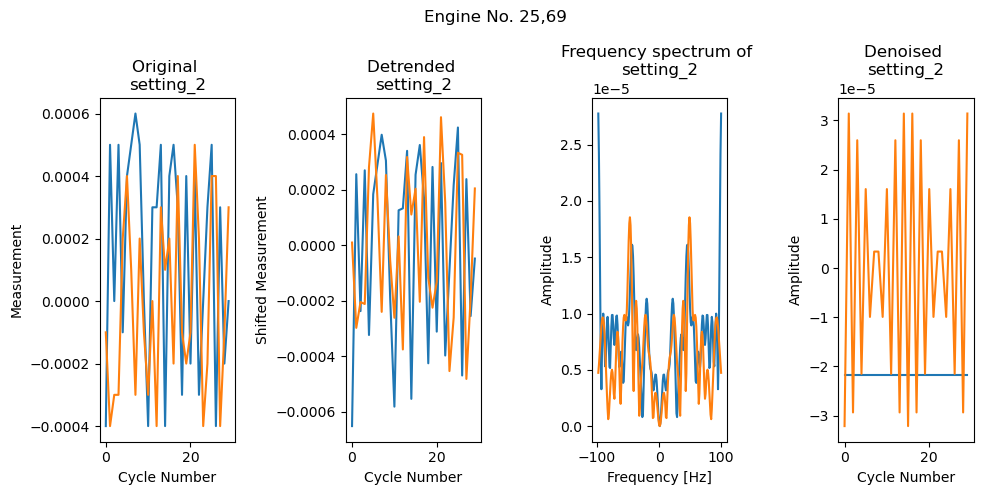

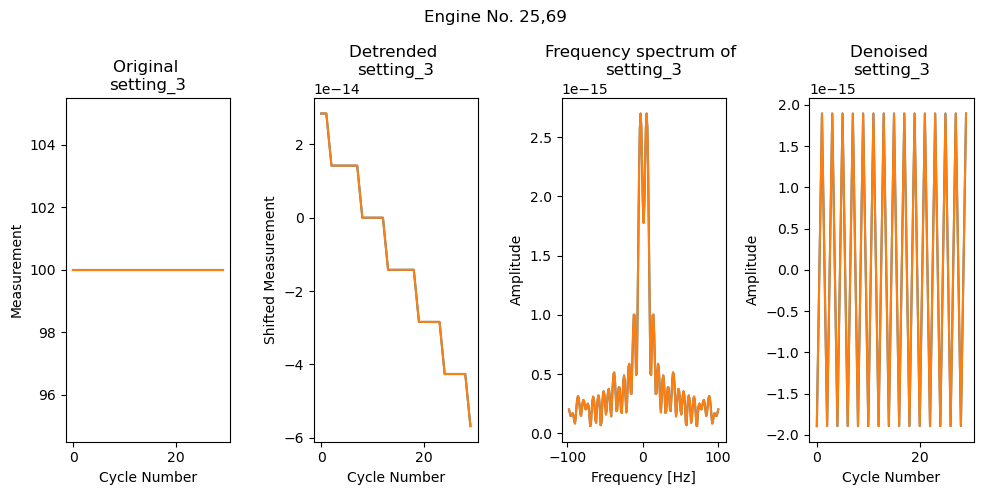

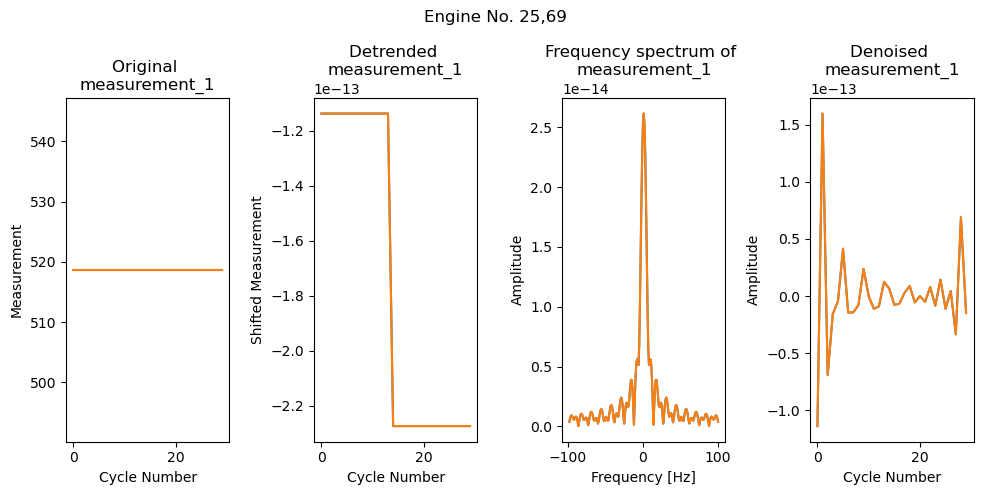

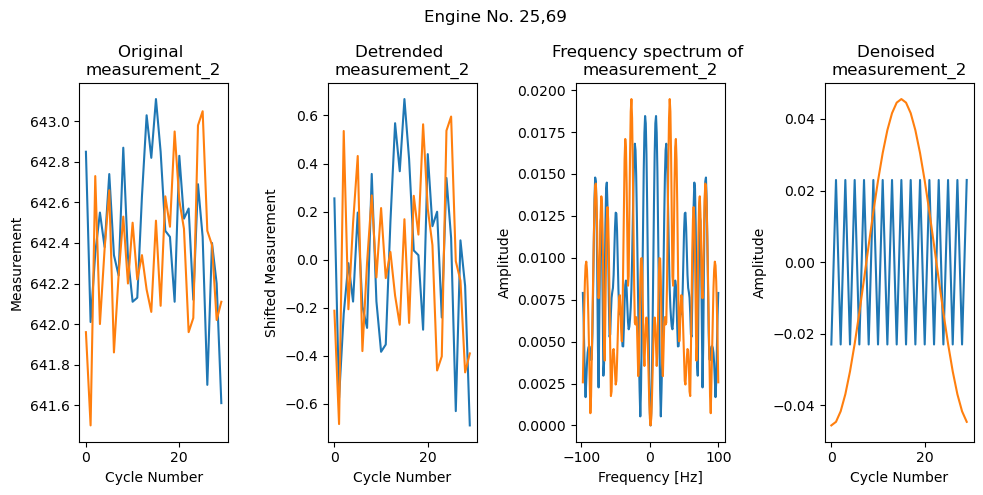

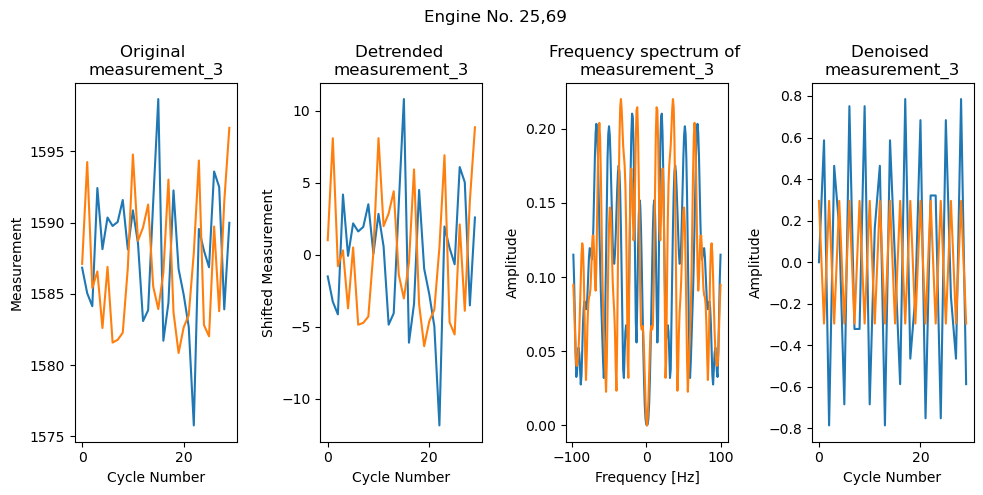

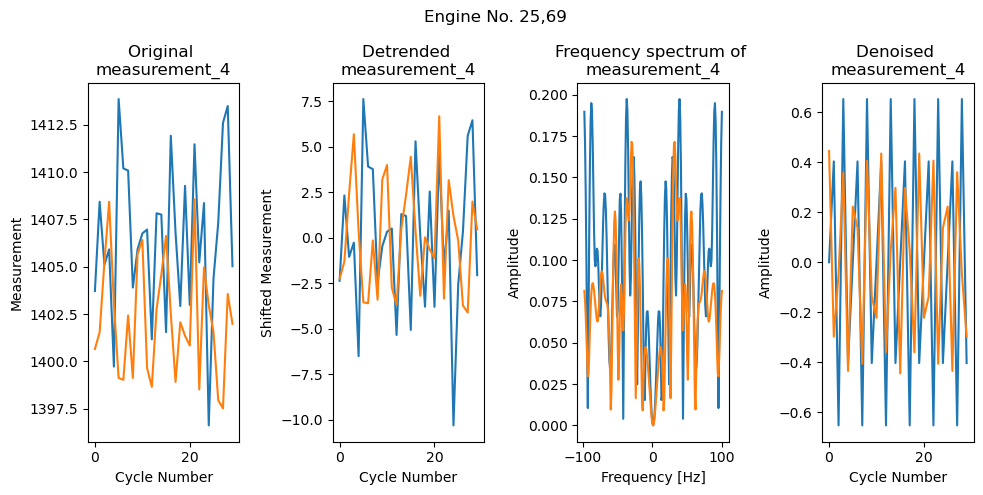

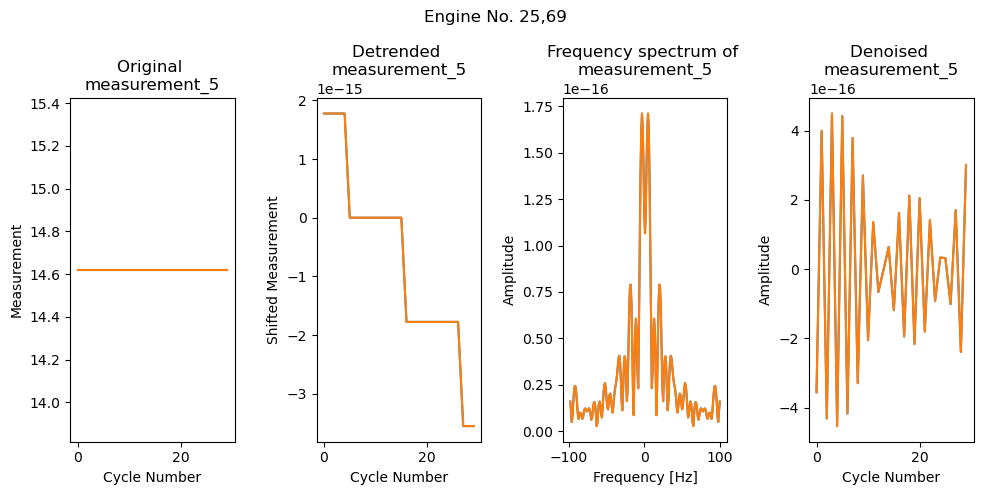

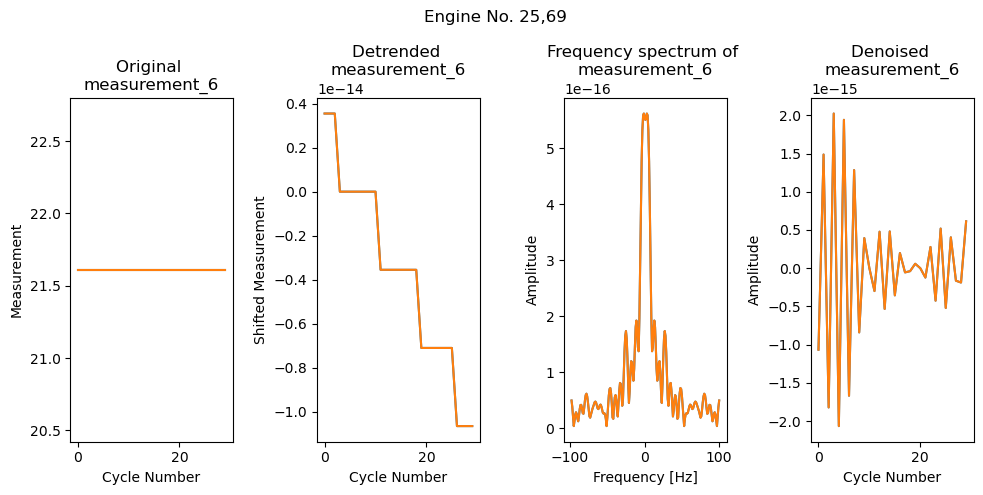

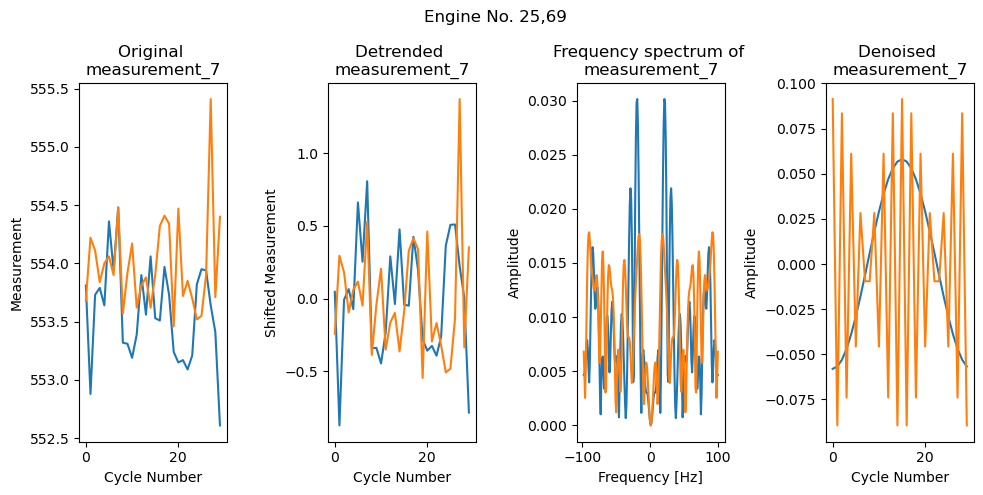

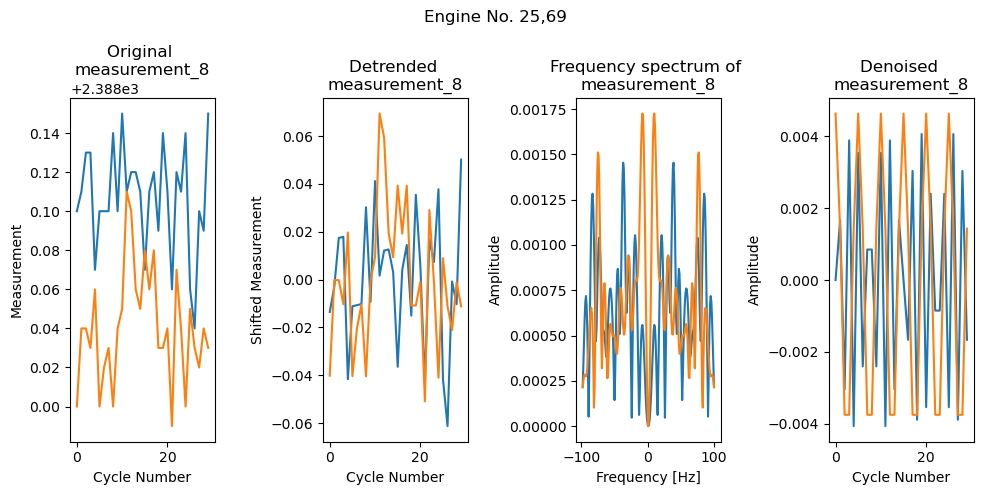

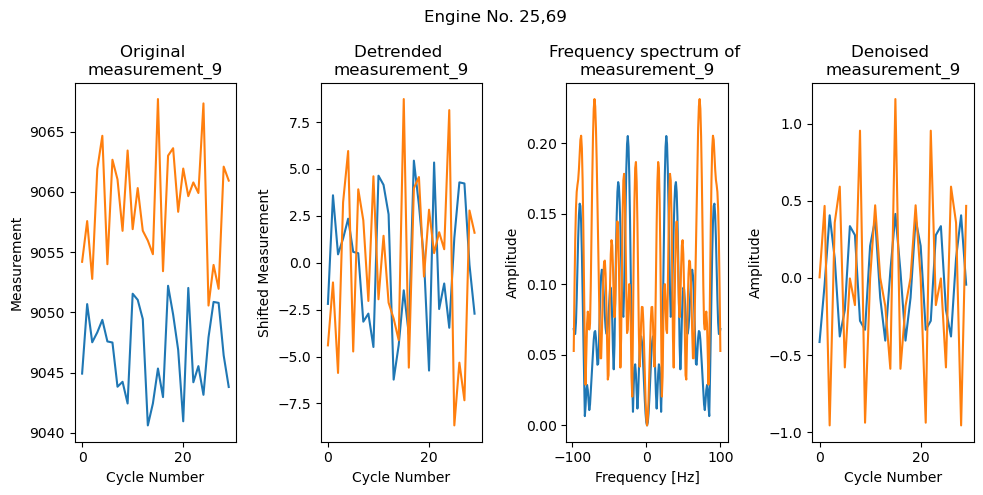

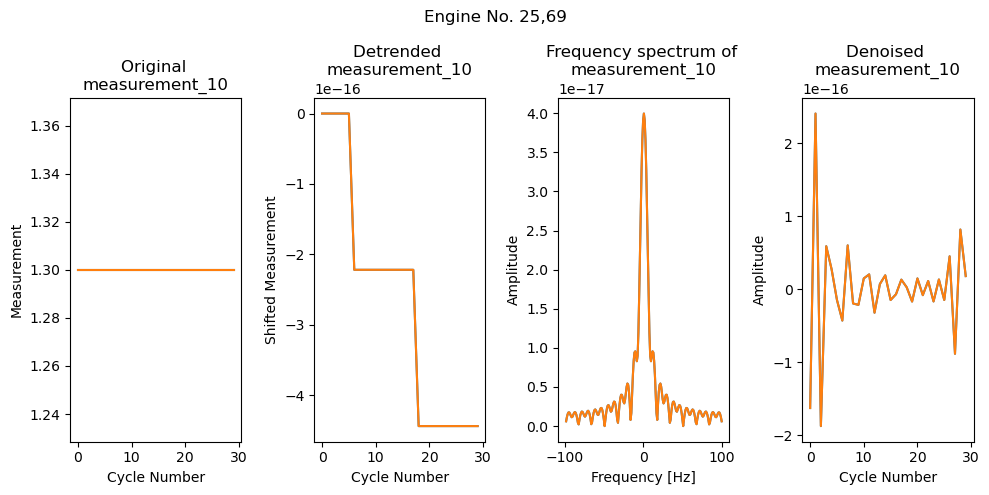

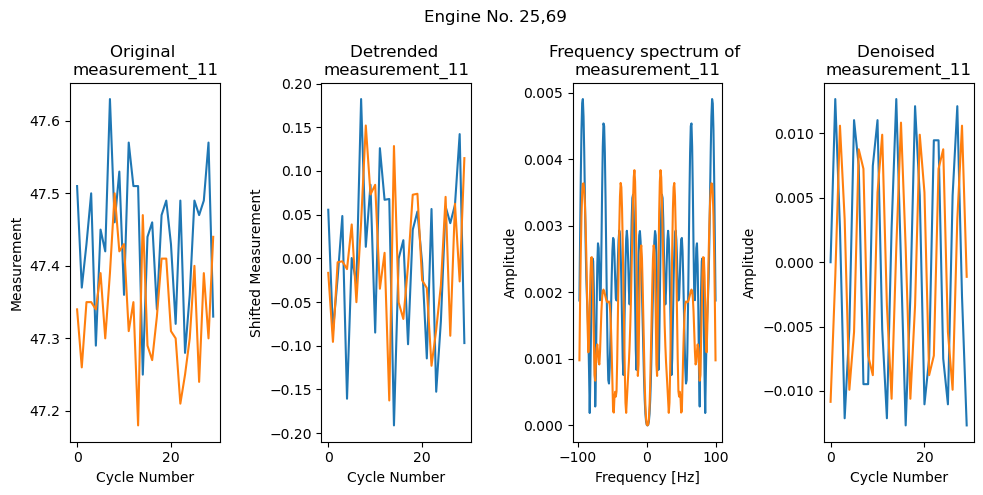

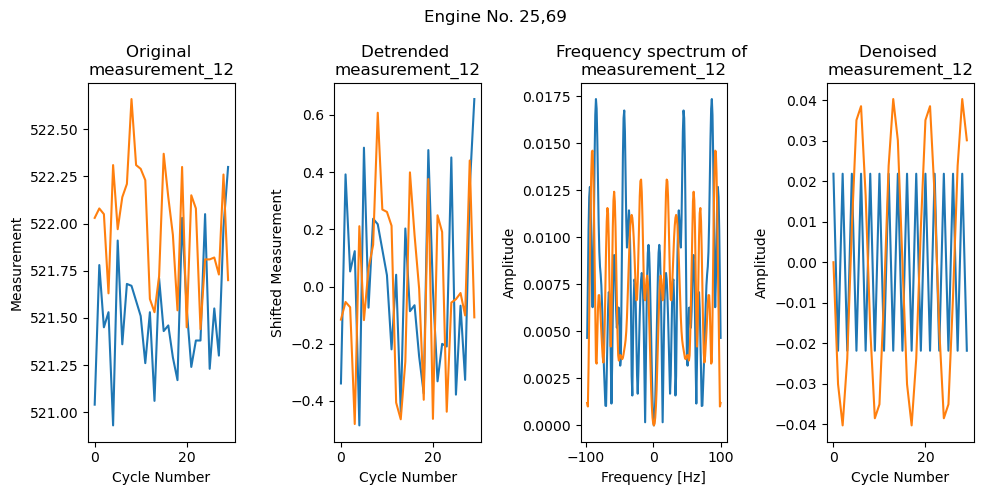

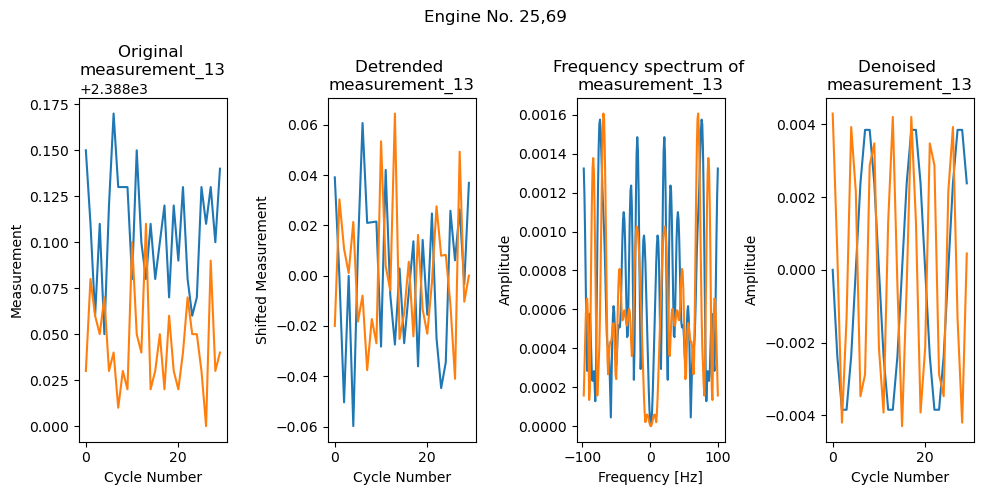

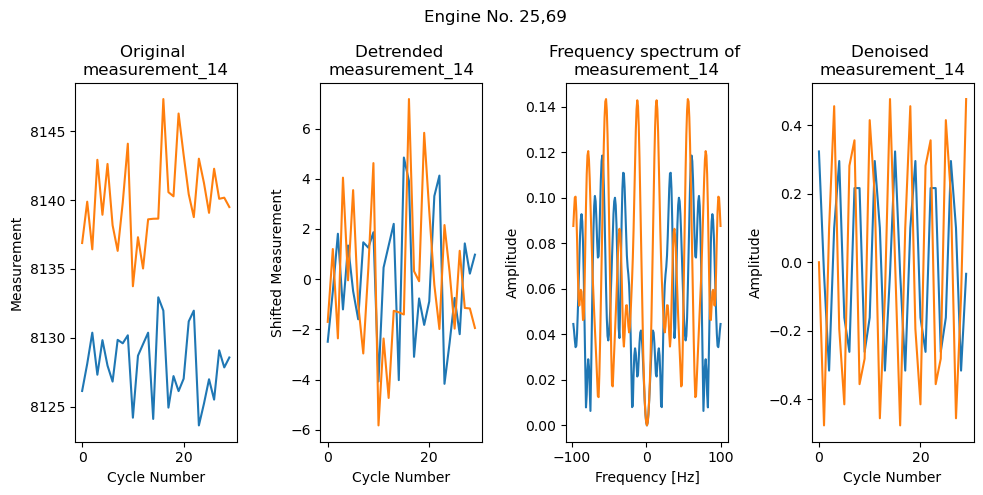

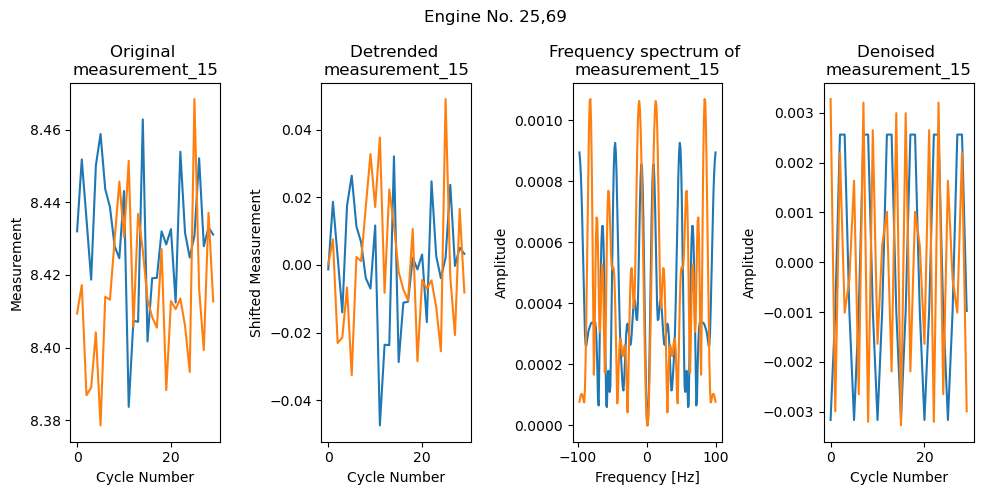

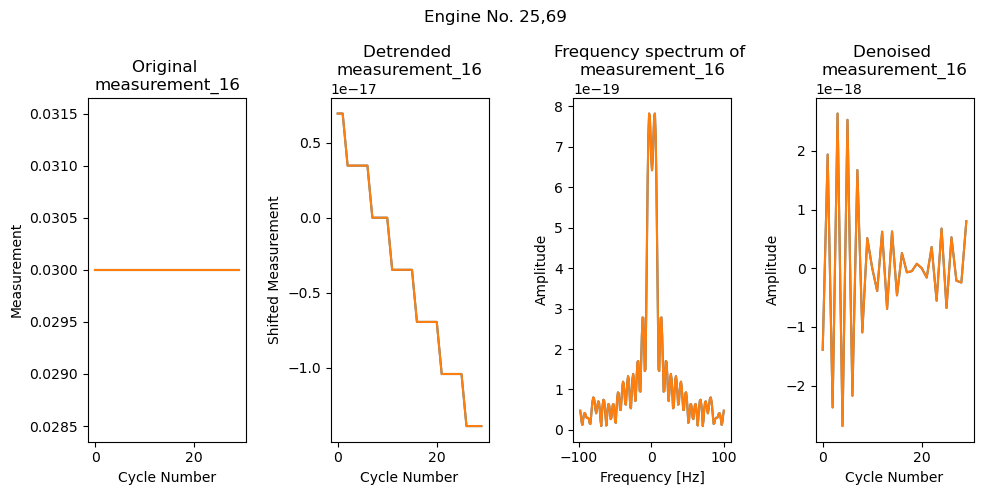

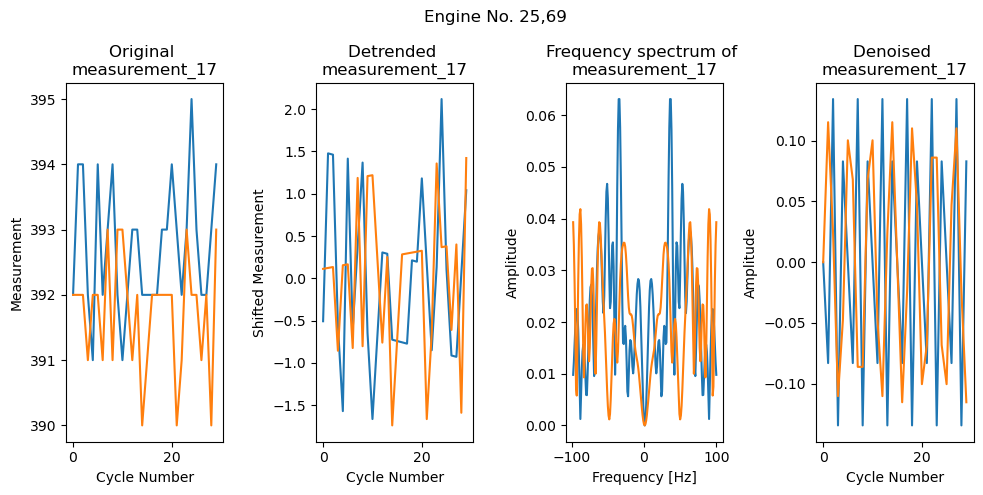

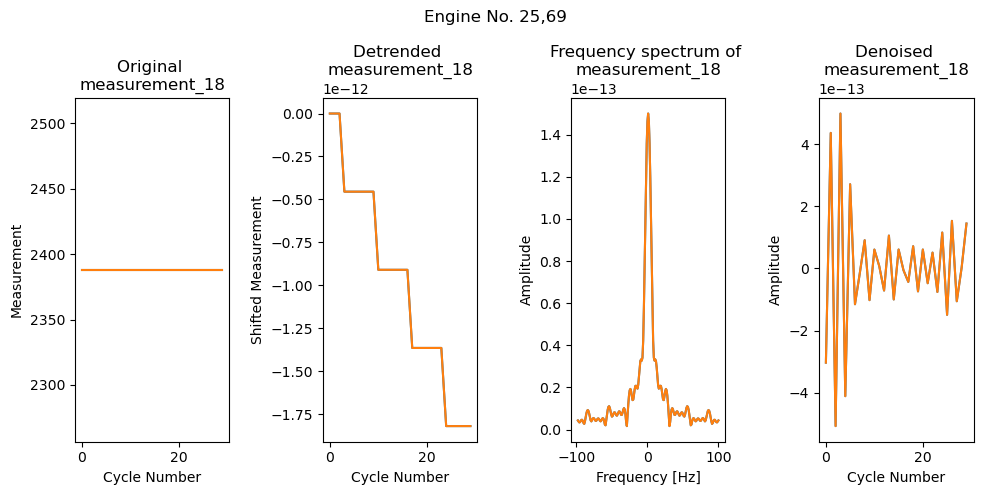

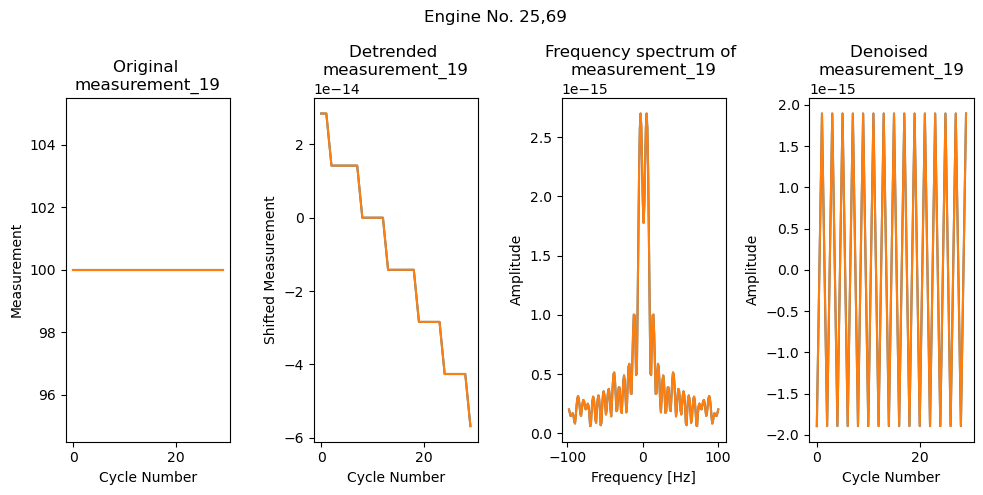

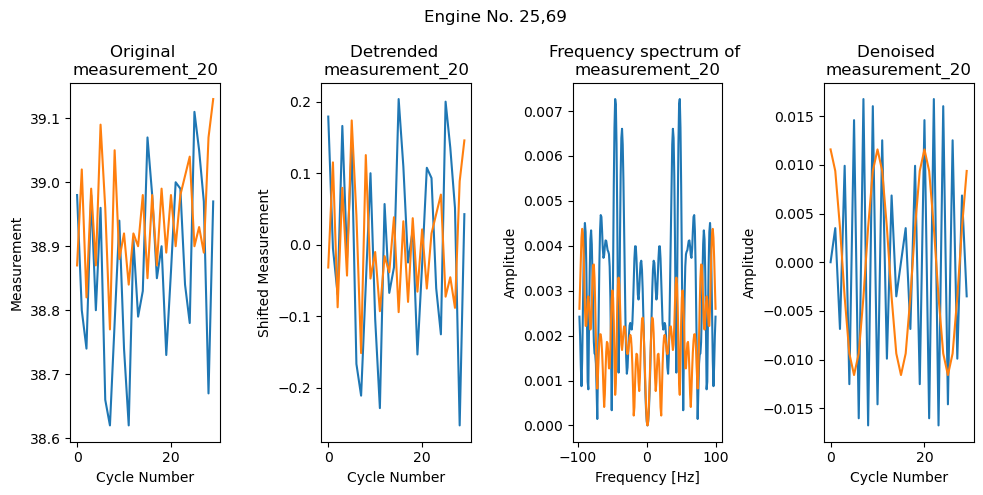

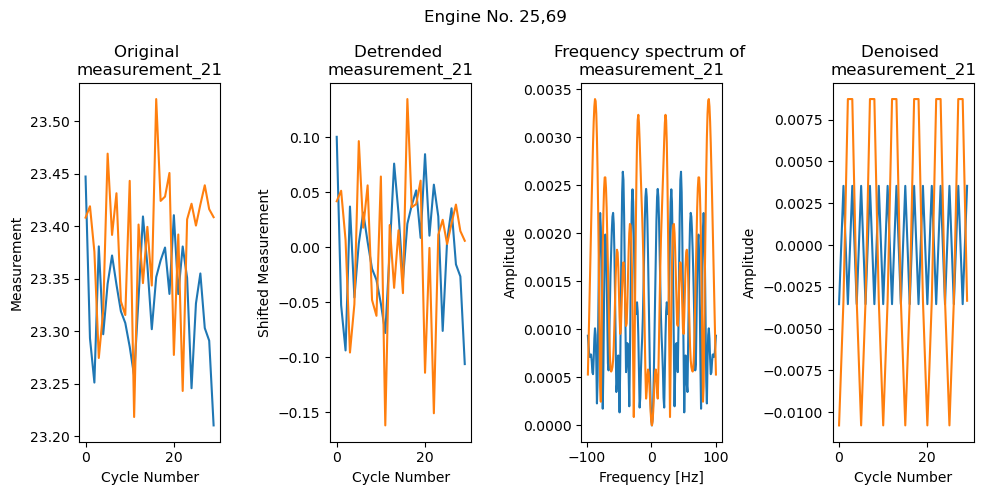

In [161]:
# Let's compare 2 engines that are known to be long-lived
for var in list(df.columns)[2:-2]:
    # print(var)
    denoise_engine_signal_one_var("25,69", df, var, start_stop_index=[0,30])

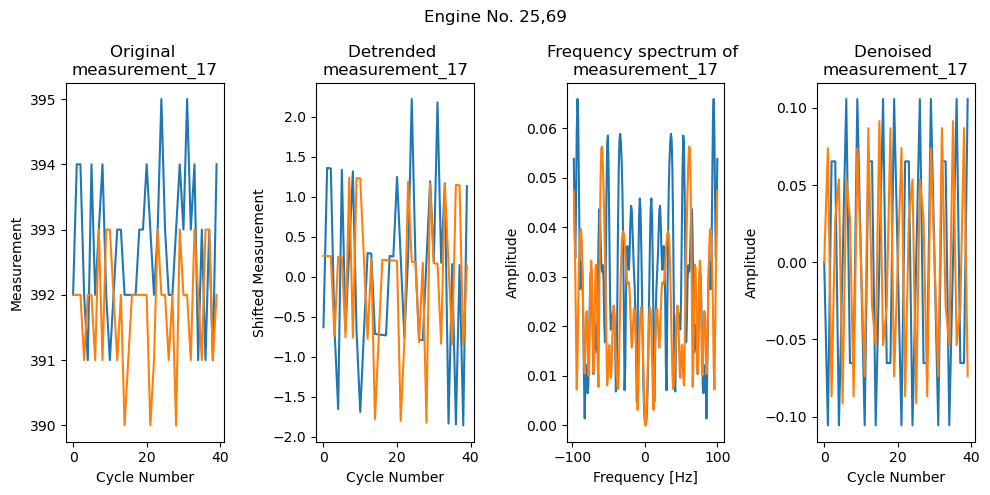

In [160]:
denoise_engine_signal_one_var("25,69", df, "sensor_measurement_17",start_stop_index=[0,40])

In [ ]:
# WORK IN PROGRESS
def denoise_engine_signal(engine_num, dataframe):

    
    # There are 26 sensors, 24 with meaningful data so let's make a 5 by 5 grid, the last 2 are NAN plots anyway
    fig, axes = plt.subplots(5, 5, figsize=(35, 35))
    fig.suptitle("Engine No. {}".format(engine_num))

    # Will attempt to denoise the signal plots using a Fourier decomposition (Inspired by the TagUp submission)
    fs = len(dataframe[dataframe["unit_number"]==engine_num]["cycle_number"].values)
    # fs = 200 # 200 Hertz
    nyq_f = fs / 2  # Nyquist frequency [Hz]


    counter=0
    for var, ax in zip(list(dataframe.columns)[2:-2], axes.flat):

        
        signal = dataframe[dataframe["unit_number"]==engine_num][var].values

        # Taking the magnitude of the components and scaling by frequency
        fft_signal = np.abs(fft(signal, fs)) / fs

        if counter==0:
            # print(fft(signal, fs))
        #     print(np.abs(fft(signal, fs)))
            print(np.abs(fft(signal, fs))/fs)
            counter+=1
            
        
        # Extract spectral components
        dc_component = fft_signal[0]
        print(dc_component)
        positive_spectrum = fft_signal[1:int(nyq_f)]
        negative_spectrum = fft_signal[int(nyq_f) + 1:]
        
        # Summing the amplitudes of the frequencies,
        spectrum = np.hstack((negative_spectrum, dc_component, positive_spectrum))
    
        
        # Frequency axis
        frequencies = np.arange(0, len(spectrum)) - len(spectrum) // 2 + 1
    
        # Establishing plot labels and plotting
        plt.title(var)
        ax.set_title("Signal " + var)
        ax.set_xlabel("Frequency [Hz]")
        ax.set_ylabel("Amplitude")
        ax.plot(frequencies,spectrum)

        
    plt.tight_layout()

In [ ]:
denoise_engine_signal(69, df)

In [ ]:
# There are 26 sensors, 24 with meaningful data so let's make a 5 by 5 grid, the last 2 are NAN plots anyway
fig, axes = plt.subplots(5, 5, figsize=(35, 35))
# fig.suptitle("Longest vs Shortest living engine")
for var, ax in zip(list(fft_df.columns)[2:], axes.flat):
    # print(var)
    sns.lineplot(data = fft_df , x = "cycle_number", y = var, 
                 # palette="colorblind",
                 ax=ax
                )
    sns.lineplot(data = fft_df_69 , x = "cycle_number", y = var, 
                 # palette="colorblind",
                 ax=ax
                )
    plt.title(var)

In [ ]:
# Let's take a look at the sensor data for units 69 and 39 which are the longest and shortest living units

# There are 26 sensors, 24 with meaningful data so let's make a 5 by 5 grid, the last 2 are NAN plots anyway
fig, axes = plt.subplots(5, 5, figsize=(35, 35))
# fig.suptitle("Longest vs Shortest living engine")
for var, ax in zip(list(fft_df.columns)[2:], axes.flat):
    # print(var)
    sns.lineplot(data = long_short_living_units , x = "cycle_number", y = var, hue=long_short_living_units["unit_number"], 
                 palette="colorblind",
                 ax=ax
                )
    plt.title(var)

In [8]:
# Let's take a look at the data, we know we have the same characteristics for multiple engines, so let's make a FacetGrid in seaborn
# Let's chunk the plots in groups of 5 
# increment = 5
# for index, section in enumerate(np.arange(5,105,increment)):
#     print(section)
#     g = sns.FacetGrid(df[(df["unit_number"]>(section-increment)) & (df["unit_number"]<=section)], col="unit_number",sharex=True)
#     g.map(sns.lineplot, "cycle_number", "operational_setting_1")
#     # g.map(sns.lineplot, "cycle_number", "sensor_measurement_20")
#     plt.show()
    
# Unit 39 dies the earliest, why?
# Units 67 and 96 are very long-lasting, why?